Enter your name: Judhajit Roy

In [ ]:
# All imports
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from torch import distributions
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fashion MNIST Dataset

import torchvision.transforms as transforms
from torchvision import datasets

# Transformations as per tensorflow 
transform = transforms.Compose([
        transforms.Lambda(lambda x: np.round(np.array(x)/27).astype(int)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))
    ])

xtrain = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=transform
    )

xtest = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



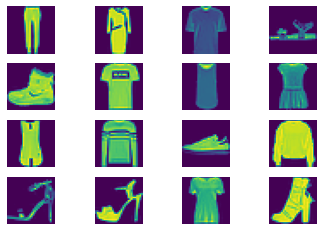

In [ ]:
def draw_grid(imlist, m, n):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))
    
draw_grid((xtrain.data).detach().numpy(), 4,4)

In [ ]:
class PixelLSTM(nn.Module):

    def __init__(self, in_dim, hid_dim, batch_size):

        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size

        self.h_W = nn.Parameter(torch.zeros(hid_dim,10))
        self.h_b = nn.Parameter(torch.zeros(batch_size,10))
        self.in_state = nn.Parameter(torch.zeros((batch_size,1),requires_grad=True)) #initial pixel

        # creating lstmcell input =1 pixel
        self.rnn = nn.LSTMCell(1, hid_dim)

    def forward_pass(self, x, get_sample=False):

        output = []
        # initial states of cell
        h = torch.zeros(self.batch_size,self.hid_dim).to(device)
        c = torch.zeros(self.batch_size,self.hid_dim).to(device)
        a = self.in_state

        for i in range(self.in_dim):

            next_h,next_c = self.rnn(a.type(torch.cuda.FloatTensor),(h,c)) #input dimension batch,1
            out_i = torch.log_softmax(next_h @ self.h_W + self.h_b,1) #(batch,hdims) * (hdims,10) + (batch,10)
            
            if get_sample:
                # generate sample
                x = torch.distributions.Categorical(logits=out_i).sample()
                x = x.unsqueeze(1)
                output.append(x)
                h,c = next_h,next_c
                a = x #next input is sampled value
            else:
                # normal pass
                out_i = out_i.unsqueeze(2)
                output.append(out_i)
                h,c = next_h,next_c
                a = x[:,i:i+1] #next input is pixel value from image

        if get_sample:
            return torch.cat(output,1)

        return torch.cat(output,2)

    def forward(self, x):
        return self.forward_pass(x)

    def sample(self):
        # a_d = self.params["c"].expand(n, -1)  # (n, H)
        # Compute p(x)
        xs = self.forward_pass(x=None,get_sample=True)
        return xs    

In [ ]:
def train(train_loader, loss_function, optimizer, model, device):
    model.train()
    train_loss = 0
    for i, (imgs,imgtype) in enumerate(train_loader):
        optimizer.zero_grad()

        inputs = imgs.type(torch.cuda.FloatTensor)
        # print(inputs.shape)
        x_hat = model(inputs)

        loss = loss_function(x_hat, imgs.type(torch.cuda.LongTensor))/imgs.size(0)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
          print("loss for batch",i,":",np.round(loss.item(),3))
    # print("Average loss:",train_loss.append(loss.item()))        
    return train_loss/(60000/imgs.size(0))

def grab_sample(model):

    # grab sample from model trained for nth epoch
    model.eval()
    xs = model.sample()
    plt.imshow(xs[0].cpu().detach().squeeze().view(28, 28).numpy())
    plt.show()     

def grab_sample_tensor(model):

    # grab sample from model trained for nth epoch
    model.eval()
    xs = model.sample()
    return xs[0]     

def testing(test_loader, loss_function, model, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (imgs,imgtype) in enumerate(test_loader):
        # for (imgs, _) in test_loader:
            x_hat = model(imgs)
            loss = loss_function(x_hat, imgs.type(torch.cuda.LongTensor))/imgs.size(0)
            test_loss += loss.item()
        print("test loss :",np.round(loss.item(),3))
    return test_loss/(10000/imgs.size(0))      

Running Epoch 1
loss for batch 0 : 1805.229
loss for batch 100 : 936.054
loss for batch 200 : 864.632
loss for batch 300 : 834.747
loss for batch 400 : 750.508
loss for batch 500 : 724.389
test loss : 708.606


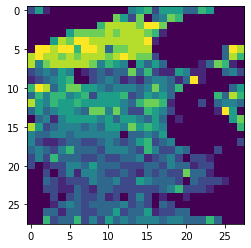

Running Epoch 2
loss for batch 0 : 690.348
loss for batch 100 : 688.434
loss for batch 200 : 690.614
loss for batch 300 : 632.034
loss for batch 400 : 643.495
loss for batch 500 : 633.733
test loss : 655.368


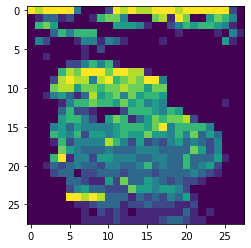

Running Epoch 3
loss for batch 0 : 640.203
loss for batch 100 : 639.988
loss for batch 200 : 606.23
loss for batch 300 : 627.983
loss for batch 400 : 619.687
loss for batch 500 : 605.542
test loss : 629.164


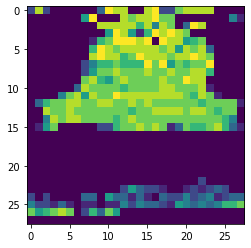

Running Epoch 4
loss for batch 0 : 597.792
loss for batch 100 : 580.747
loss for batch 200 : 619.921
loss for batch 300 : 578.303
loss for batch 400 : 621.346
loss for batch 500 : 621.937
test loss : 612.576


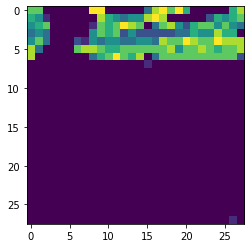

Running Epoch 5
loss for batch 0 : 589.007
loss for batch 100 : 571.015
loss for batch 200 : 569.235
loss for batch 300 : 596.664
loss for batch 400 : 579.425
loss for batch 500 : 565.661
test loss : 597.351


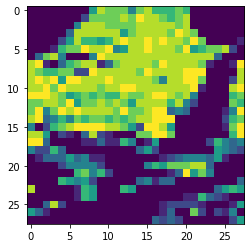

In [ ]:
data_path = "data"
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
batch_size = 100

train_loader = torch.utils.data.DataLoader(xtrain, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(xtest, batch_size=batch_size, shuffle=False)

model = PixelLSTM(in_dim=784, hid_dim=150,batch_size=batch_size).to(device)
loss_function = nn.NLLLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(),lr= 0.001)

# start training
train_losses = []
test_losses = []

for e in range(epochs):
    print("Running Epoch",e+1)

    train_loss = train(train_loader, loss_function, optimizer, model, device)
    test_loss = testing(test_loader, loss_function,  model, device)  

    # grabbing one sample to show improvement
    grab_sample(model)

    # store loss values
    train_losses.append(train_loss)
    test_losses.append(test_loss)


In [ ]:
torch.save(model.state_dict(), "pixellstmmodel1.pt")    

In [ ]:
model = PixelLSTM(in_dim=784, hid_dim=150,batch_size=100).to(device)
model.load_state_dict(torch.load("/content/pixellstmmodel1.pt"))

<All keys matched successfully>

Text(0, 0.5, 'Negative Log Likelihood loss')

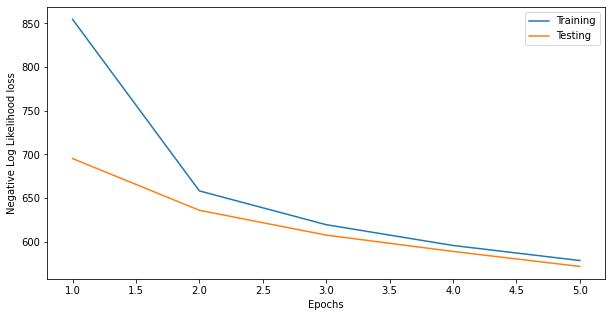

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(x=range(1,6), y=train_losses)
sns.lineplot(x=range(1,6), y=test_losses)
plt.legend(labels=['Training', 'Testing'])
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood loss")

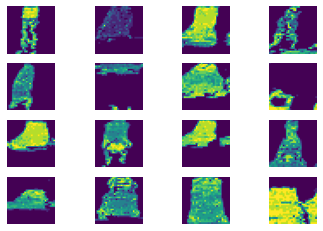

In [ ]:
# 16 samples
def draw_grid(imlist, m, n):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))

g = []
for i in range(16):
  g.append(grab_sample_tensor(model).cpu())

draw_grid(g, 4,4)

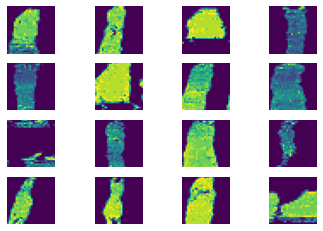

In [ ]:
g2 = []
for i in range(16):
  g2.append(grab_sample_tensor(model).cpu())

draw_grid(g2, 4,4)